Loading dataset...

--- No Feature Selection ---
No Feature Selection completed in 0.67 seconds with 30 features.

--- Shapely Select with p-value=0.01 ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/

Shapely Select with p-value 0.01 completed in 41.28 seconds with 6 selected features: ['V14', 'V17', 'V4', 'V8', 'V10', 'V26']

--- Shapely Select with p-value=0.02 ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/

Shapely Select with p-value 0.02 completed in 29.96 seconds with 6 selected features: ['V14', 'V17', 'V4', 'V8', 'V10', 'V26']

--- Shapely Select with p-value=0.03 ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/

Shapely Select with p-value 0.03 completed in 32.94 seconds with 6 selected features: ['V14', 'V17', 'V4', 'V8', 'V10', 'V26']

--- Shapely Select with p-value=0.04 ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/

Shapely Select with p-value 0.04 completed in 34.04 seconds with 7 selected features: ['V14', 'V17', 'V4', 'V8', 'V10', 'V26', 'Amount']

--- Shapely Select with p-value=0.05 ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/

Shapely Select with p-value 0.05 completed in 33.59 seconds with 8 selected features: ['V14', 'V17', 'V4', 'V8', 'V10', 'V26', 'Amount', 'V12']

--- Shapely Select with p-value=0.07 ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/

Shapely Select with p-value 0.07 completed in 37.50 seconds with 8 selected features: ['V14', 'V17', 'V4', 'V8', 'V10', 'V26', 'Amount', 'V12']

--- Shapely Select with p-value=0.1 ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 31 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 30 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/

Shapely Select with p-value 0.1 completed in 36.40 seconds with 9 selected features: ['V14', 'V17', 'V4', 'V8', 'V10', 'V26', 'Amount', 'V12', 'V18']
Saved plot for Shapely Select p-value benchmarking.

--- SHAP Selection ---
SHAP Selection completed in 1.75 seconds with 15 selected features: Index(['V14', 'V4', 'V12', 'V10', 'V3', 'V8', 'V19', 'Time', 'V15', 'Amount',
       'V7', 'V26', 'V5', 'V6', 'V16'],
      dtype='object')

--- RFE ---
RFE completed in 9.06 seconds with 15 selected features: Index(['Time', 'V1', 'V3', 'V4', 'V7', 'V8', 'V10', 'V12', 'V14', 'V16', 'V17',
       'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

--- HISEL ---
HISEL completed in 139.07 seconds with 30 selected features: ['V28', 'Time', 'Amount', 'V27', 'V26', 'V25', 'V24', 'V23', 'V22', 'V21', 'V20', 'V19', 'V18', 'V17', 'V16', 'V14', 'V2', 'V6', 'V5', 'V9', 'V1', 'V7', 'V8', 'V4', 'V3', 'V12', 'V15', 'V13', 'V11', 'V10']

--- Boruta ---
Boruta completed in 41.97 seconds with 10 selected featur

,Method,Selected Features,Accuracy,F1 Score,Runtime (s)
0,No Feature Selection,30,0.999614,0.870588,0.666203
1,Shapely Select (p=1%),6,0.999625,0.873016,41.278282
2,Shapely Select (p=2%),6,0.999625,0.873016,29.960288
3,Shapely Select (p=3%),6,0.999625,0.873016,32.939579
4,Shapely Select (p=4%),7,0.999637,0.875502,34.040012
5,Shapely Select (p=5%),8,0.999661,0.884462,33.587693
6,Shapely Select (p=7%),8,0.999661,0.884462,37.495704
7,Shapely Select (p=10%),9,0.999637,0.875502,36.402660
8,SHAP Selection,15,0.999649,0.880000,1.748370
9,RFE,15,0.999625,0.873016,9.062131


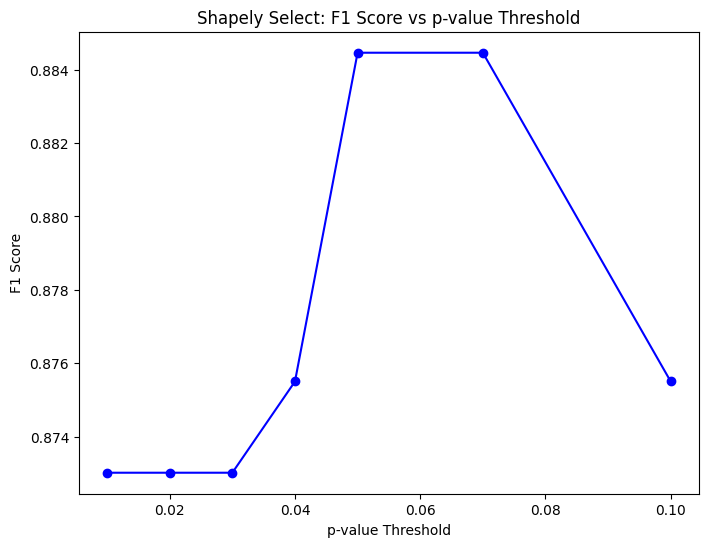

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from boruta import BorutaPy
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import time
from shap_select import shap_select
from skfeature.function.information_theoretical_based import MRMR
from shap_selection import feature_selection

# Define common XGBoost model
def train_xgboost(X_train, y_train):
    params = {"objective": "binary:logistic", "eval_metric": "logloss", "verbosity": 0}
    dtrain = xgb.DMatrix(X_train, label=y_train)
    xgb_model = xgb.train(params, dtrain, num_boost_round=100)
    return xgb_model

def predict_xgboost(xgb_model, X_val):
    dval = xgb.DMatrix(X_val)
    y_pred = (xgb_model.predict(dval) > 0.5).astype(int)
    return y_pred

# HISEL feature selection using MRMR
def hisel_feature_selection(X_train, y_train, num_features):
    selected_idx = MRMR.mrmr(X_train.values, y_train.values, n_selected_features=num_features)
    return X_train.columns[selected_idx].tolist()

# Run experiments with different feature selection methods and shap-select p-values
def run_experiments():
    print("Loading dataset...")
    df = pd.read_csv('creditcard.csv')
    X = df.drop(columns=['Class'])
    y = df['Class']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    results = []
    shapely_select_results = []

    # No Feature Selection
    print("\n--- No Feature Selection ---")
    start_time = time.time()
    xgb_model = train_xgboost(X_train, y_train)
    y_pred = predict_xgboost(xgb_model, X_val)
    runtime = time.time() - start_time
    print(f"No Feature Selection completed in {runtime:.2f} seconds with {len(X_train.columns)} features.")
    results.append({
        'Method': 'No Feature Selection',
        'Selected Features': len(X_train.columns),
        'Accuracy': accuracy_score(y_val, y_pred),
        'F1 Score': f1_score(y_val, y_pred),
        'Runtime (s)': runtime
    })

    # Shapely Select with different p-values
    for p_value in [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.1]:
        print(f"\n--- Shapely Select with p-value={p_value} ---")
        start_time = time.time()
        shap_features, _ = shap_select(xgb_model, X_val, y_val, task="binary", alpha=1e-6, threshold=p_value, return_extended_data=True)
        selected_features = shap_features[shap_features["selected"] == 1]["feature name"].tolist()
        runtime = time.time() - start_time
        print(f"Shapely Select with p-value {p_value} completed in {runtime:.2f} seconds with {len(selected_features)} selected features: {selected_features}")

        xgb_model_shap = train_xgboost(X_train[selected_features], y_train)
        y_pred_shap = predict_xgboost(xgb_model_shap, X_val[selected_features])

        f1_score_shap = f1_score(y_val, y_pred_shap)
        shapely_select_results.append({'p_value': p_value, 'F1 Score': f1_score_shap})

        results.append({
            'Method': f'Shapely Select (p={int(p_value*100)}%)',
            'Selected Features': len(selected_features),
            'Accuracy': accuracy_score(y_val, y_pred_shap),
            'F1 Score': f1_score_shap,
            'Runtime (s)': runtime
        })

    # Plot F1 Score vs p-value for Shapely Select
    plt.figure(figsize=(8, 6))
    p_values = [entry['p_value'] for entry in shapely_select_results]
    f1_scores = [entry['F1 Score'] for entry in shapely_select_results]
    plt.scatter(p_values, f1_scores, color='blue')
    plt.plot(p_values, f1_scores, linestyle='-', color='blue')
    plt.xlabel("p-value Threshold")
    plt.ylabel("F1 Score")
    plt.title("Shapely Select: F1 Score vs p-value Threshold")
    plt.savefig("shapely_select_p_value_benchmark.png")
    print("Saved plot for Shapely Select p-value benchmarking.")

    # SHAP Selection
    print("\n--- SHAP Selection ---")
    start_time = time.time()
    selected_shap_selection, _ = feature_selection.shap_select(xgb_model, X_train, X_val, X_train.columns, agnostic=False)
    selected_shap_selection = selected_shap_selection[:15]
    shap_selection_time = time.time() - start_time
    print(f"SHAP Selection completed in {shap_selection_time:.2f} seconds with {len(selected_shap_selection)} selected features: {selected_shap_selection}")

    xgb_model_shap_selection = train_xgboost(X_train[selected_shap_selection], y_train)
    y_pred_shap_selection = predict_xgboost(xgb_model_shap_selection, X_val[selected_shap_selection])

    results.append({
        'Method': 'SHAP Selection',
        'Selected Features': len(selected_shap_selection),
        'Accuracy': accuracy_score(y_val, y_pred_shap_selection),
        'F1 Score': f1_score(y_val, y_pred_shap_selection),
        'Runtime (s)': shap_selection_time
    })

    # RFE
    print("\n--- RFE ---")
    rfe_start_time = time.time()
    rfe = RFE(xgb.XGBClassifier(use_label_encoder=False), n_features_to_select=15)
    rfe.fit(X_train, y_train)
    selected_rfe = X_train.columns[rfe.support_]
    rfe_time = time.time() - rfe_start_time
    print(f"RFE completed in {rfe_time:.2f} seconds with {len(selected_rfe)} selected features: {selected_rfe}")

    xgb_model_rfe = train_xgboost(X_train[selected_rfe], y_train)
    y_pred_rfe = predict_xgboost(xgb_model_rfe, X_val[selected_rfe])

    results.append({
        'Method': 'RFE',
        'Selected Features': len(selected_rfe),
        'Accuracy': accuracy_score(y_val, y_pred_rfe),
        'F1 Score': f1_score(y_val, y_pred_rfe),
        'Runtime (s)': rfe_time
    })

    # HISEL
    print("\n--- HISEL ---")
    hisel_start_time = time.time()
    selected_hisel = hisel_feature_selection(X_train, y_train, num_features=15)
    hisel_time = time.time() - hisel_start_time
    print(f"HISEL completed in {hisel_time:.2f} seconds with {len(selected_hisel)} selected features: {selected_hisel}")

    xgb_model_hisel = train_xgboost(X_train[selected_hisel], y_train)
    y_pred_hisel = predict_xgboost(xgb_model_hisel, X_val[selected_hisel])

    results.append({
        'Method': 'HISEL',
        'Selected Features': len(selected_hisel),
        'Accuracy': accuracy_score(y_val, y_pred_hisel),
        'F1 Score': f1_score(y_val, y_pred_hisel),
        'Runtime (s)': hisel_time
    })

    # Boruta
    print("\n--- Boruta ---")
    boruta_start_time = time.time()
    rf_model = xgb.XGBClassifier(use_label_encoder=False)
    boruta_selector = BorutaPy(rf_model, n_estimators='auto', random_state=1)
    boruta_selector.fit(X_train.values, y_train.values)
    selected_boruta = X_train.columns[boruta_selector.support_].tolist()
    boruta_time = time.time() - boruta_start_time
    print(f"Boruta completed in {boruta_time:.2f} seconds with {len(selected_boruta)} selected features: {selected_boruta}")

    xgb_model_boruta = train_xgboost(X_train[selected_boruta], y_train)
    y_pred_boruta = predict_xgboost(xgb_model_boruta, X_val[selected_boruta])

    results.append({
        'Method': 'Boruta',
        'Selected Features': len(selected_boruta),
        'Accuracy': accuracy_score(y_val, y_pred_boruta),
        'F1 Score': f1_score(y_val, y_pred_boruta),
        'Runtime (s)': boruta_time
    })

    results_df = pd.DataFrame(results)
    print("\n--- Experiment Results ---")
    print(results_df)
    return results_df

# Run the experiments
run_experiments()


In [1]:
!pip3 install shap-select==0.1.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shap-select: filename=shap_select-0.1.0-py3-none-any.whl size=10499 sha256=1d879e1b717c1c63c7c95bb7a605965618199e393a4291bc6f841172e9923bb4
  Stored in directory: /Users/baran.koseoglu/Library/Caches/pip/wheels/db/8e/89/b9036b114c0d8320ba07cd4296d266bf8f81fd8bd8b3d21d23
Successfully built shap-select


In [1]:
!pip3 install shap-selection
